# Cas Kaggle: Predicció del Guanyador de Partides d’Escacs (Lichess)

**Autors:** Naroa Sarrià (1706167), Inés Gómez (1704361)  
**Assignatura:** Aprenentatge Computacional – UAB (2025)

**Dataset original:** https://www.kaggle.com/datasnaek/chess  
**Repositori GitHub:** https://github.com/NIU1706167/CasKaggle-Chess


## 2. Preprocessing  i Feature Engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("games_EDA.csv")

Primer de tot mirem si tenim variables NaN's a les dades

In [3]:
df.isna().mean().sort_values(ascending=False)

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

Veiem que no hi ha cap NaN, de manera que passem a codificar el nostre target (**winner**) per tenir-lo com a 1 (white) i 0 (black)

In [4]:
df['winner'] = df['winner'].replace({'white': 1, 'black': 0})

C:\Users\nsarr\AppData\Local\Temp\ipykernel_4012\1425917397.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['winner'] = df['winner'].replace({'white': 1, 'black': 0})


A continuació ens dedicarem a fer una cerca d'outliers. Analitzarem la variable "turns" ja que és la única en la que ens podem trobar valors inusuals.

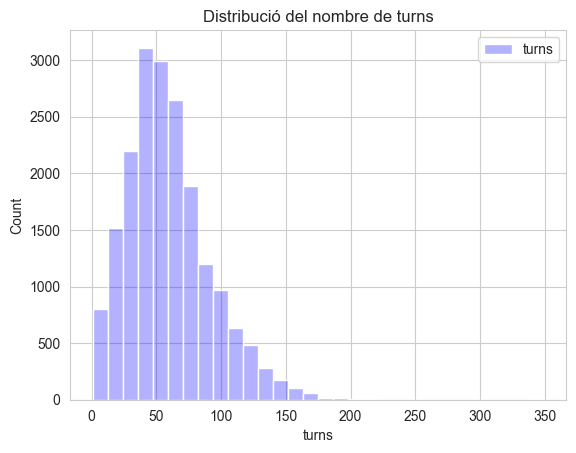

In [5]:
sns.histplot(df["turns"], bins=30, color="blue", alpha=0.3, label="turns")
plt.title("Distribució del nombre de turns")
plt.legend()
plt.show()

In [6]:
df["turns"].describe()

count    19108.000000
mean        59.188664
std         32.310010
min          1.000000
25%         37.000000
50%         54.000000
75%         77.000000
max        349.000000
Name: turns, dtype: float64

El nombre mínim de turns que es necessiten per poder guanyar una partida és 4, de manera que mirarem quantes partides tenim que tenen un nombre inferior a aquest i, seguidament, les eliminarem, ja que són partides que no ens aporten informació útil.

In [7]:
valor = (df["turns"] < 4).sum()
print("Nombre de partides amb un nombre de turns menor a 4:",valor)

Nombre de partides amb un nombre de turns menor a 4: 277


Com només són 277 partides (de gairebé 20000 partides que tenim al conjunt de dades), ens podem permetre treure aquestes del nostre dataset, per tal d'evitar que valors inconsistents ens afectin el nostre model. 

In [8]:
df = df[df["turns"] >= 4]
valor = (df["turns"] < 4).sum()
print("Comprovem que ara hi ha",valor,"partides amb menys de 4 moviments.")

Comprovem que ara hi ha 0 partides amb menys de 4 moviments.


Mirem ara valors massa elevats. Una partida amb més de 200 moviments són casos molt extrems, que no passen gairebé mai, per tant, podem mirar quants casos tenim i, si són pocs, els podrem eliminar, ja que no representen bé les nostres dades.

In [9]:
valor = (df["turns"] > 200 ).sum()
print("Tenim",valor,"partides amb més de 200 moviments.")

Tenim 11 partides amb més de 200 moviments.


In [10]:
#Com només són 11 partides, les podem eliminar.
df = df[df["turns"] <= 200]
valor = (df["turns"] > 200 ).sum()
print("Tenim",valor,"partides amb més de 200 moviments.")

Tenim 0 partides amb més de 200 moviments.


A continuació, començarem a tractar i a fer feature engineering amb les variables conegudes que tenim. Començarem primer afegint variables que podem conèixer prèvies al començament d'una partida.

Comencem per tant creant la variable **diff_rating** que serà la diferència entre els ratings dels dos jugadors (white_rating - black_rating)

In [11]:
df["diff_rating"] = df["white_rating"] - df["black_rating"]

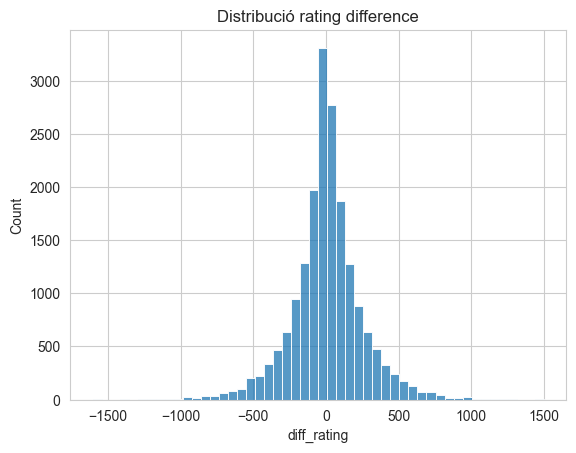

In [12]:
sns.histplot(df["diff_rating"], bins=50)
plt.title("Distribució rating difference")
plt.show()

Ara farem variables que vagin acumulant el winrate global dels dos jugadors que s'enfrenten en cada partida fins aquell moment. Aquesta variable es calcularà com: $$\text{winrate} = \frac{\text{partides guanyades fins al moment}}{\text{partides totals jugades}}$$

Per fer aquestes variables, i les que farem a continuació, hem d'ordenar primerament les partides cronològicament

In [13]:
df['created_at'] = pd.to_datetime(df['created_at'], unit='ms')

# Ordenem per data
df = df.sort_values('created_at')

In [14]:
winning = {}

white_global_winrate = []
black_global_winrate = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"]  # 1 = white, 0 = black

    # Inicialitzem historial si encara no surt
    if white not in winning:
        winning[white] = { "total_matches" : 0, "wins" : 0}
    
    if black not in winning:
        winning[black] = { "total_matches" : 0, "wins" : 0}

    #Calculem winrate
    if (winning[white]["total_matches"] > 0):
        rate = winning[white]["wins"] / winning[white]["total_matches"]
        white_global_winrate.append(rate)
    else:
        white_global_winrate.append(0)


    if (winning[black]["total_matches"] > 0):
        rate = winning[black]["wins"] / winning[black]["total_matches"]
        black_global_winrate.append(rate)
    else:
        black_global_winrate.append(0)

    
    #Afegir la partida actual
    winning[white]["total_matches"] += 1
    if(winner == 1):
        winning[white]["wins"] += 1

    winning[black]["total_matches"] += 1
    if(winner == 0):
        winning[black]["wins"] += 1


# Afegim variable al DataFrame
df["white_global_winrate"] = white_global_winrate
df["black_global_winrate"] = black_global_winrate
# fem diferència del winrate
df["diff_global_winrate"] = df["white_global_winrate"] - df["black_global_winrate"]

Ara fem les següents noves variables explicatives per a cada parella de jugadors que s'enfrenten:
* **vs_white_winrate**: es un percentatge de victòries prèvies del jugador que juga amb blanques contra aquell mateix rival abans de la partida actual. Cal esmentar que els empats compten com 0,5.
* **vs_prev_matches**: Nombre total de partides que els dos jugadors havien jugat prèviament entre ells (sense importar colors ni resultats).

In [15]:
history = {}

vs_white_winrate = []
vs_prev_matches = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    winner = row["winner"] 

    pair = tuple(sorted([white, black]))

    if pair not in history:
        history[pair] = {
            "white_wins_player1": 0,
            "white_wins_player2": 0,
            "total_matches": 0
        }
        # La parella encara no s'havia enfrentat
        vs_white_winrate.append(0.0)
        vs_prev_matches.append(0)
    else:
        p1, p2 = pair

        # Determinar vegades ha guanyat el blanc abans
        if white == p1:
            prev_white_wins = history[pair]["white_wins_player1"]
        else:
            prev_white_wins = history[pair]["white_wins_player2"]

        prev_total = history[pair]["total_matches"]

        # Calcular winning rate del blanc
        rate = prev_white_wins / prev_total if prev_total > 0 else 0.0
        
        vs_white_winrate.append(rate)
        vs_prev_matches.append(prev_total)

    # Actualizar historial després de registrar les dades prèvies
    if winner == 1: 
        if white == pair[0]:
            history[pair]["white_wins_player1"] += 1
        else:
            history[pair]["white_wins_player2"] += 1
            
    history[pair]["total_matches"] += 1

# Afegir columnes al DataFrame
df["vs_white_winrate"] = vs_white_winrate
df["vs_prev_matches"] = vs_prev_matches


Ara veurem que tenim a la base de dades molts jugadors que juguen recurrentment (ja sigui amb blanques o negres) cosa que ens motiva per crear una nova variable amb l'experiència de cada jugador.
* **white_experience**: nombre total de partides que el jugador que porta blanques havia jugat abans de la partida actual (experiència acumulada).
* **black_experience**: nombre total de partides que el jugador que porta negres havia jugat abans de la partida actual.
* **diff_exp**: diferència de experiència entre els dos jugadors: $$\text{diff\_exp} = \text{white\_experience - black\_experience}$$

In [16]:
experience = {}

diff_exp = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]

    if white not in experience:
        experience[white] = {"total_matches": 0}
    if black not in experience:
        experience[black] = {"total_matches": 0}

    # diferència
    diff_exp.append(experience[white]["total_matches"] - experience[black]["total_matches"])
    
    # Actualitzar después
    experience[white]["total_matches"] += 1
    experience[black]["total_matches"] += 1
    
df["diff_experience"] = diff_exp

També serà molt interessant tenir unes variables amb les ratxes de victòries de cada jugador. D'aquesta manera tindrem un recompte de les victòries consecutives de cada jugador, definint les noves variables explicatives:
* **white_win_streak**: ratxa de victòries consecutives del jugador que porta blanques fins a la partida actual.
    - Una victòria suma +1 a la ratxa.
    - Una derrota fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
* **black_win_streak**: ratxa de victòries consecutives del jugador que porta negres fins a la partida actual.
    - Una victòria suma +1 a la ratxa.
    - Una derrota (o si la ratxa es talla) fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
* **white_loss_streak**: ratxa de derrotes consecutives del jugador que porta blanques fins a la partida actual.
    - Una derrota suma +1 a la ratxa.
    - Una victòria fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).
* **black_loss_streak**: ratxa de derrotes consecutives del jugador que porta negres fins a la partida actual.
    - Una derrota suma +1 a la ratxa.
    - Una victòria fa que la ratxa es reiniciï a 0 o es mantingui a 0 (si ja estava a 0).

A més, afegim dues variables que són la diferència de les ratxes, per després valorar quina variable és més rellevant.
$$\text{diff\_win\_streak} = \text{white\_win\_streak - black\_win\_streak}$$
$$\text{diff\_loss\_streak} = \text{white\_loss\_streak - black\_loss\_streak}$$
Així podem fer un seguiment de la ratxa de cada jugador en funció de les victòries i derrotes a mesura que avancen les partides.

In [17]:
history = {}

white_win_streak = []
white_loss_streak = []
black_win_streak = []
black_loss_streak = []

for _, row in df.iterrows():
    white = row["white_id"]
    black = row["black_id"]
    result = row["winner"]   # 1 = guanya blanc, 0 = guanya negre

    if white not in history:
        history[white] = {"win": 0, "loss": 0}
    if black not in history:
        history[black] = {"win": 0, "loss": 0}

    white_win_streak.append(history[white]["win"])
    white_loss_streak.append(history[white]["loss"])
    black_win_streak.append(history[black]["win"])
    black_loss_streak.append(history[black]["loss"])

    if result == 1:
        history[white]["win"]  += 1
        history[white]["loss"]  = 0
        history[black]["loss"] += 1
        history[black]["win"]   = 0

    else:
        history[white]["loss"] += 1
        history[white]["win"]   = 0
        history[black]["win"]  += 1
        history[black]["loss"]  = 0


df["white_win_streak"] = white_win_streak
df["white_loss_streak"] = white_loss_streak
df["black_win_streak"] = black_win_streak
df["black_loss_streak"] = black_loss_streak

df["diff_win_streak"] = df["white_win_streak"] - df["black_win_streak"]
df["diff_loss_streak"] = df["white_loss_streak"] - df["black_loss_streak"]


A continuació, mirarem la matriu de correlacions amb aquestes variables que acabem de crear i la variable objectiu.

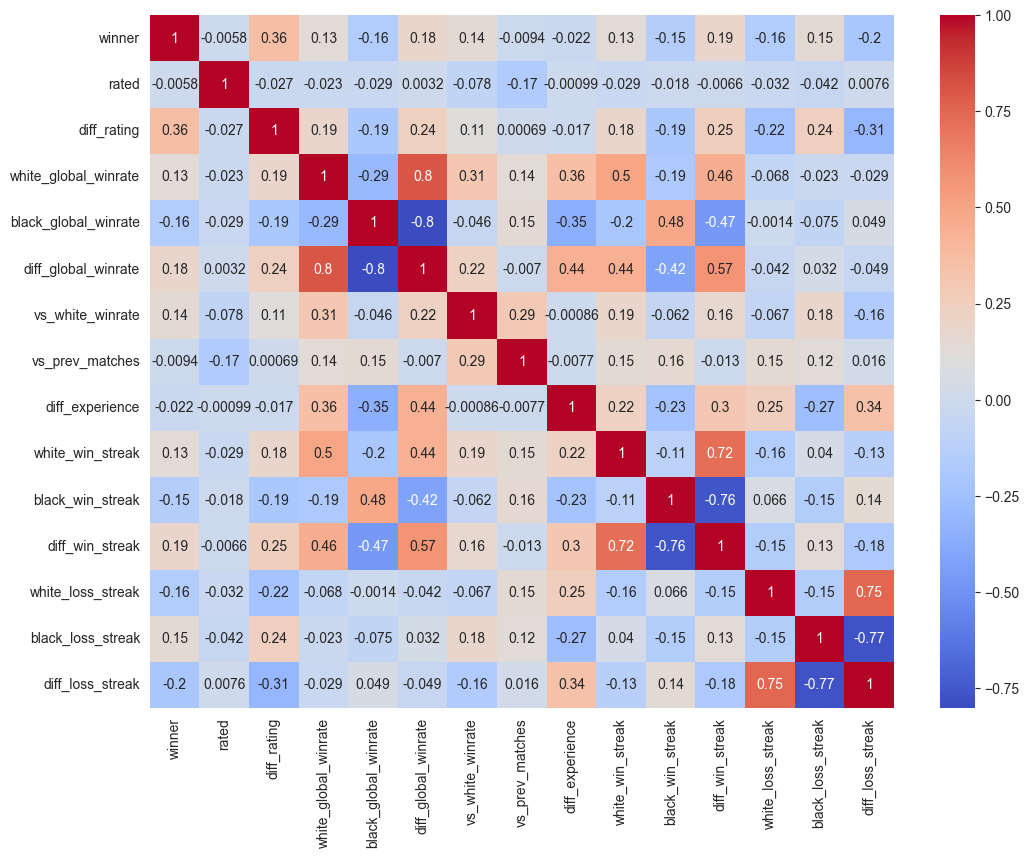

In [18]:
variables_previes = ['winner','rated', 'diff_rating', 
                     'white_global_winrate', 'black_global_winrate','diff_global_winrate',
                     'vs_white_winrate', 'vs_prev_matches',
                     'diff_experience',
                     'white_win_streak','black_win_streak','diff_win_streak',
                     'white_loss_streak','black_loss_streak','diff_loss_streak']
corr_matrix = df[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Ara, comencem a tractar les variables que tenen en compte la partida ja començada.

Primer canviarem les variables de opening_eco per codificar només el tipus d'obertura:
Códigos ECO (A–E)
* A – Obertures de flanc i poc comunes
* B – Obertures semiobertes
* C – Obertures obertes
* D – Obertures tancades i semitancades
* E – Obertures de peó de dama amb defensa índia

In [19]:
# Creem nova columna amb la lletra de l'obertura
df["opening_group"] = df["opening_eco"].astype(str).str[0]
df["opening_group"].value_counts()

opening_group
C    7268
B    4895
A    3656
D    2527
E     474
Name: count, dtype: int64

In [20]:
# les codifiquem per tenir 5 columnes amb True i False
df = pd.get_dummies(df, columns=["opening_group"], drop_first=False)

A continuació crearem variables per quan volem afegir més moviments de la partida. Les variables noves seran les següents:
* **white_piece_count / black_piece_count:** nombre total de peces que té cada jugador encara sobre el tauler.
* **white_material_value / black_material_value:** suma del “valor” de totes les peces de cada bàndol segons la taula estàndard:
    - Peó = 1
    - Cavall = 3
    - Alfil = 3
    - Torre = 5
    - Reina = 9
    - Rei = 0 (si no tenim rei ja s'ha acabat la partida)
* **material_balance:** diferència entre white_material_value i black_material_value. Si el valor es positiu hi ha un avantatge material per les blanques (les peces que té són més bones), si és negatiu, l'avantatge el té les negres.
* **white_center_control / black_center_control:** nombre de caselles centrals controlades per les blanques o per les negres.
* **white_mobility / black_mobility:** determina quants moviments legals té cada color si li toqués jugar ara.
* **white_PST / black_PST:** valor posicional total sumat peça per peça segons els PST (les Piece-Square Tables són taules que assignen un valor a una peça depenent d'on es trobi, ja que hi ha peces que ens interessa més que estiguin en unes caselles en específic). Mesura com de bones són les posicions de les peces de cada bàndol.
* **white_space:** nombre de caselles en la meitat negra del tauler que són atacades per les blanques.
* **black_space:** Nombre de caselles en la meitat blanca del tauler que són atacades per les negres.

In [21]:
import chess

# Funció que retorna l'estat del tauler a partir dels moviments
def board_after_n_moves(moves_str, n_moves=None):
    board = chess.Board()
    moves = moves_str.split()
    
    if n_moves is not None:
        moves = moves[:n_moves]

    for mv in moves:
        try:
            board.push_san(mv)  # SAN = notació estàndard
        except:
            break  

    return board


piece_values = {
    chess.PAWN:   1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK:   5,
    chess.QUEEN:  9,
    chess.KING:   0
}

# Funció que retorna noves variables creades. (nº de peces, valor de las peces)
def material_features(board):
    white_total = 0
    black_total = 0
    white_count = 0
    black_count = 0
    
    for piece in board.piece_map().values():
        value = piece_values[piece.piece_type]
        
        if piece.color == chess.WHITE:
            white_total += value
            white_count += 1
        else:
            black_total += value
            black_count += 1
    
    return {
        "white_piece_count": white_count,
        "black_piece_count": black_count,
        "white_material_value": white_total,
        "black_material_value": black_total,
        "material_balance": white_total - black_total
    }

CENTER_SQUARES = [
    chess.D4, chess.E4, chess.D5, chess.E5
]

# Funció que retorna els valors per mirar el control del centre del tauler
def center_control(board):    
    white = 0
    black = 0
    
    for sq in CENTER_SQUARES: 
        attackers_white = board.attackers(chess.WHITE, sq) 
        attackers_black = board.attackers(chess.BLACK, sq)
        
        if attackers_white:
            white += 1
        if attackers_black:
            black += 1
            
    return {
        "white_center_control": white,
        "black_center_control": black
    }

PST = {
    chess.PAWN: np.array([
        0, 0, 0, 0, 0, 0, 0, 0,
        5, 10, 10,-20,-20, 10, 10, 5,
        5, -5,-10, 0, 0,-10, -5, 5,
        0, 0, 0, 20, 20, 0, 0, 0,
        5, 5,10,25,25,10,5,5,
        10,10,20,30,30,20,10,10,
        50,50,50,50,50,50,50,50,
        0,0,0,0,0,0,0,0
    ]),
    chess.KNIGHT: np.array([
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20, 0, 0, 0, 0,-20,-40,
        -30, 0,10,15,15,10,0,-30,
        -30, 5,15,20,20,15,5,-30,
        -30, 0,15,20,20,15,0,-30,
        -30, 5,10,15,15,10,5,-30,
        -40,-20, 0,5,5,0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50
    ]),
    chess.BISHOP: np.zeros(64),
    chess.ROOK: np.zeros(64),
    chess.QUEEN: np.zeros(64),
    chess.KING: np.zeros(64),
}



def mobility_for_color(board, color):
    b2 = board.copy()
    b2.turn = color
    return b2.legal_moves.count()



def pst_score(board, color):
    total = 0
    for sq, p in board.piece_map().items():
        val = PST.get(p.piece_type)
        if val is None:
            continue
        index = sq
        if p.color == chess.BLACK:
           
            index = chess.square_mirror(index)
        total += val[index] * (1 if p.color==color else -1)
    return total if color==chess.WHITE else -total


# afegim variables creades
def positional_features(board):
    feats = {}
    feats.update({
        "white_mobility": mobility_for_color(board, chess.WHITE),
        "black_mobility": mobility_for_color(board, chess.BLACK),
        "white_PST": pst_score(board, chess.WHITE),
        "black_PST": pst_score(board, chess.BLACK),
    })
    # espai: casillas controlades en la meitat rival
    white_half = [sq for sq in chess.SQUARES if chess.square_rank(sq) >= 4]  # ranks 5-8 => 4..7
    black_half = [sq for sq in chess.SQUARES if chess.square_rank(sq) <= 3]  # ranks 1-4 => 0..3
    feats["white_space"] = sum(1 for sq in white_half if board.attackers(chess.WHITE, sq))
    feats["black_space"] = sum(1 for sq in black_half if board.attackers(chess.BLACK, sq))
    return feats


Creem també les funcions per poder afegir aquestes variables al nostre DataFrame.

In [22]:
def extract_features_from_moves(moves_str, n_moves=None):
    board = board_after_n_moves(moves_str, n_moves)
    
    feats = {}
    feats.update(material_features(board))
    feats.update(center_control(board))
    feats.update(positional_features(board))
    
    return feats

def add_move_features(df,n_moves=None):
    feature_rows = []

    if not hasattr(n_moves, "__iter__"):
        n_moves = pd.Series([n_moves] * len(df), index=df.index)

    for moves, n in zip(df["moves"], n_moves):
        if pd.isna(n):
            feature_rows.append(extract_features_from_moves(moves, None))
        else:
            feature_rows.append(extract_features_from_moves(moves, int(n)))

    feature_df = pd.DataFrame(feature_rows)
    return pd.concat([df, feature_df], axis=1)

def count_plies(moves_str):
    if pd.isna(moves_str):
        return 0
    return len(moves_str.split())

A continuació, mirarem les correlacions d'aquestes noves variables juntament amb la variable objectiu. Ho farem per partides que van per 50 moviments.

In [23]:
df["num_plies"] = df["moves"].apply(count_plies)

df_filtered = df[df["num_plies"] >= 55].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Afegir features amb N moviments per partida
df_filtered = add_move_features(df_filtered, n_moves=55)

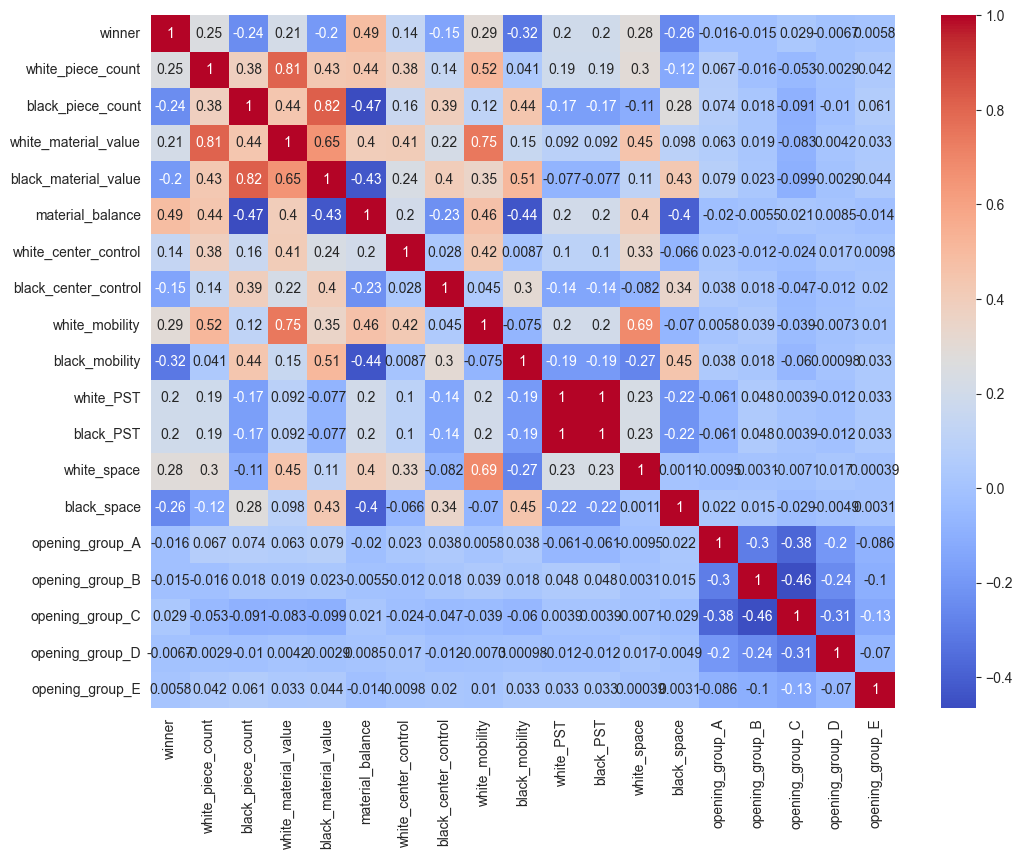

In [24]:
variables = [
    'winner',

    # Material
    'white_piece_count', 'black_piece_count',
    'white_material_value', 'black_material_value', 'material_balance',
    

    # Control del centre
    'white_center_control',
    'black_center_control',
    
    # Mobilitat
    'white_mobility',
    'black_mobility',
    
    # PST / Piece-Square Table
    'white_PST',
    'black_PST',
    
    # Espai 
    'white_space',
    'black_space',

    # Obertures
    'opening_group_A', 'opening_group_B', 'opening_group_C', 'opening_group_D', 'opening_group_E'
]
corr_matrix = df_filtered[variables].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

Podem veure que totes les variables tenen una correlació mínimament alta, excepte els grups d'apertura, de manera que decidim treure aquests, ja que no ens aporten informació útil.

In [25]:
df.tail()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,black_win_streak,black_loss_streak,diff_win_streak,diff_loss_streak,opening_group_A,opening_group_B,opening_group_C,opening_group_D,opening_group_E,num_plies
13045,qCmTWffu,True,2017-09-04 01:27:41.297,1.504489e+12,55,mate,1,10+0,networkchess2,1940,...,0,0,2,0,False,False,False,True,False,55
15811,5JxE5a6e,True,2017-09-04 01:28:53.111,1.504489e+12,61,mate,1,10+0,elijahreese,1871,...,0,0,1,0,True,False,False,False,False,61
15810,8Xr8Hmp7,True,2017-09-04 01:41:20.676,1.504490e+12,48,resign,0,10+0,elijahreese,1873,...,0,0,2,0,False,False,True,False,False,48
18549,dGvzzC9L,True,2017-09-04 02:30:59.427,1.504493e+12,67,resign,1,10+0,samoo1477,1754,...,0,1,1,-1,False,False,True,False,False,67
18548,mLY9CCtH,True,2017-09-04 02:45:43.790,1.504494e+12,65,resign,1,10+0,vertis9016,1822,...,2,0,-2,2,False,False,True,False,False,65


Ara que ja tenim totes les nostres variables explicatives, normalitzem totes les numèriques per tenir-les en el mateix rang.

In [26]:
scaler = StandardScaler()

# Solo normalizamos variables numéricas que nos interesan
num_vars = ['rated', 'diff_rating', 
            'white_global_winrate', 'black_global_winrate','diff_global_winrate',
            'vs_white_winrate', 'vs_prev_matches',
            'diff_experience',
            'white_win_streak','black_win_streak','diff_win_streak',
            'white_loss_streak','black_loss_streak','diff_loss_streak',
            'opening_group_A','opening_group_B','opening_group_C','opening_group_D','opening_group_E']
df[num_vars] = scaler.fit_transform(df[num_vars])

Ens guardem el nostre nou dataset amb els canvis realitzats, per poder començar a entrenar models

In [27]:
df.to_csv('games_preprocessed.csv',index=False)